<h1 align="center" style="color:red"> 
    <b>
        Momentum Term for the Learning Rate
    </b>
</h1>

### Example: Circular and Elliptical Surfaces with GDE

In this example we compare the stochastic gradient descent (GDE) behavior on surfaces with circular and elliptical shapes.

We used the **same objective and hypothesis functions** in both cases, the only difference being the **variation range** of one of the attributes.

GDE uses the same learning step and number of epochs in both cases.

In [93]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import random

### Definition of functions.

In [94]:
# learning schedule: Time Based Decay
def timeBasedDecay(alpha_int, k, t):
    return alpha_int / (1 + k*t)

# learning schedule: Exponential Decay.
def exponentialDecay(alpha_int, k, t):
    return alpha_int * np.exp(-k*t)

# learning schedule: Gradual Decay
def stepDecay(alpha_int, t, drop=0.5, epochs_drop = 4.0):
    alpha = alpha_int * math.pow(drop, math.floor((1+t)/epochs_drop))
    return alpha

def learning_schedule(typels, alpha_int, t, k=0.01, mu=0.9):
    if(typels=='exp'):
        mom = 0.0
        alpha = exponentialDecay(alpha_int, k, t)
    elif(typels=='time'):
        mom = 0.0
        alpha = timeBasedDecay(alpha_int, k, t)
    elif(typels=='step'):
        mom = 0.0
        alpha = stepDecay(alpha_int, t)
    elif(typels=='mom'):
        mom = mu
        alpha = alpha_int
    elif(typels=='momstep'):
        mom = mu
        alpha = stepDecay(alpha_int, t)
    else:
        mom = 0.0
        alpha = alpha_int
    return alpha, mom

def sgd(X, y_noisy, n_epochs, typels, alpha_init, k=0.01, mu=0.9, seed=42):
    '''Stocastic Gradient Descent implementation.'''
    
    # Reset pseudo-random generator.
    random.seed(seed)
    
    # Number of examples.
    N = len(y_noisy)
    
    # Random initialization of parameters.
    a = np.array([-6.0, -6.0]).reshape(2, 1)

    # Create vector for parameter history.
    a_hist = np.zeros((2, n_epochs*N+1))

    # Initialize history vector.
    a_hist[:, 0] = a.reshape(2,)

    # Create vector to store eta history.
    alpha_hist = np.zeros((n_epochs*N))

    # Momentum term.
    v = np.zeros((2, 1))

    # Create array for storing error values.
    Jgd = np.zeros(n_epochs*N+1)

    # Calculate initial MSE.
    Jgd[0] = (1.0/N)*sum(np.power(y_noisy - X.dot(a), 2))

    update_hist = np.zeros((2, n_epochs*N))

    # Stocastic gradient-descent loop.
    for epoch in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        shuffled_indexes = random.sample(range(0, N), N)  

        for i in range(N):
            # Retrieve one pair of attribute vector and label.
            random_index = shuffled_indexes[i]
            xi = X[random_index:random_index+1]
            yi = y_noisy[random_index:random_index+1]

            # Update the learning rate value.
            alpha, mu = learning_schedule(typels, alpha_init, (epoch*N + i), k, mu)
            
            # Estimate the gradient with just one sample.
            gradient = -2.0*xi.T.dot(yi - xi.dot(a))
            
            # Update the weights with the momentum term.
            v = mu*v - alpha*gradient
            a = a + v

            # Update arrays with history values.
            a_hist[:, epoch*N+i+1] = a.reshape(2,)
            update_hist[:, epoch*N+i] = v.reshape(2,)
            alpha_hist[epoch*N+i] = alpha

            # Calculate the current MSE.
            Jgd[epoch*N+i+1] = (1.0/N)*sum(np.power((y_noisy - X.dot(a)), 2))
    return a, Jgd, a_hist, update_hist, alpha_hist

### Circular surface.

The variation range of the attributes is similar.

In [95]:
# Always reset the pseudo random number generator to the same number.
seed = 1012019
np.random.seed(seed)
random.seed(seed)

In [96]:
# Define the number of examples.
N = 1000

# Features.
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2

# Observable model.
y_noisy = y + w

In [97]:
# Generate values for parameters.
M = 200
a1 = np.linspace(-6.0, 8.0, M)
a2 = np.linspace(-6.0, 8.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    for iter2 in range(0, M):
        yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
        J[iter1, iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))

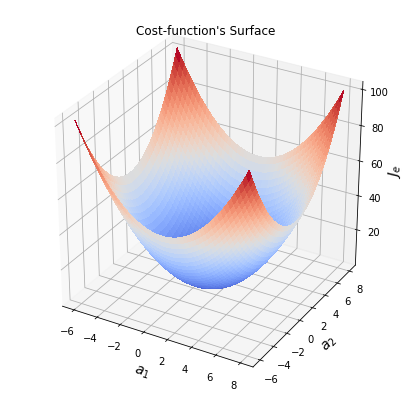

In [98]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

In [99]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

# Hypothesis function.
yhat = X.dot(a_opt)

# Mean Squared Error.
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

print('Joptimum:', Joptimum)

Joptimum: 0.9692215285411728


In [100]:
# Number of epochs.
n_epochs = 1

# Learning rate.
alpha_sgd = 0.06

# Training without schedule learning
a_sgd, Jgd, a_hist, update_hist, alpha_hist = sgd(X, y_noisy, n_epochs, 'none', alpha_sgd, 0.01, 0.0, seed)

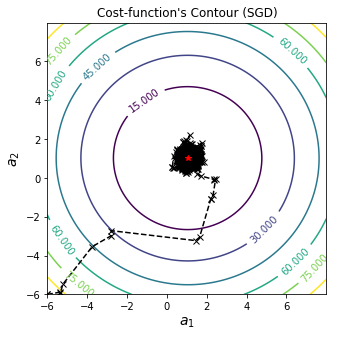

In [101]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (SGD)')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-6, 8, step=2.0))
plt.yticks(np.arange(-6, 8, step=2.0))
plt.xlim([-6, 8])
plt.show()

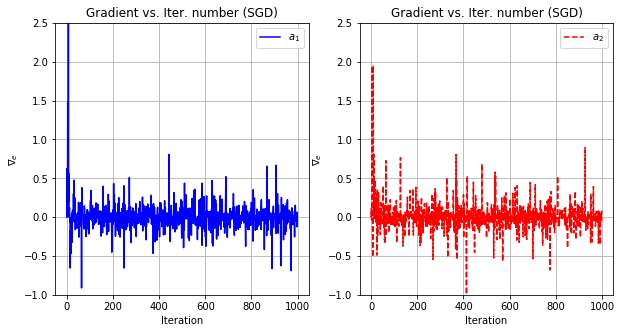

In [102]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1, 2.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (SGD)')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1, 2.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (SGD)')
ax2.legend()
ax2.grid()

plt.show()

In [103]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:',var1)
print('var a2:',var2)

var a1: 0.040090168503535174
var a2: 0.030461240242039656


**Conclusions**

+ The variance values ​​show that the gradient varies equally in both directions (i.e., circular surface).
+ The updates are noisy and, therefore, the algorithm does not always follow in the direction of maximum slope of the function.
+ However, the algorithm quickly approaches the region where the global minimum is found.
+ Because the error surface is circular, the GDE does not oscillate along the slopes of the ravine, making rapid progress towards the global minimum region.

<img src="../../../../img/superficie_circular.png" width="300px">

### Elliptical surface.

The variation range of the attributes is different. In the example below, attribute $x_1$ has a standard deviation 10 times greater than attribute $x_2$.

In [104]:
# Always reset the pseudo random number generator to the same number.
seed = 1012019
np.random.seed(seed)
random.seed(seed)

In [105]:
# Define the number of examples.
N = 1000

# Features.
x1 = 10*np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2

# Observable model.
y_noisy = y + w

In [106]:
# Generate values for parameters.
M = 200
a1 = np.linspace(-7.0, 8.0, M)
a2 = np.linspace(-7.0, 8.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    for iter2 in range(0, M):
        yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
        J[iter1, iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))

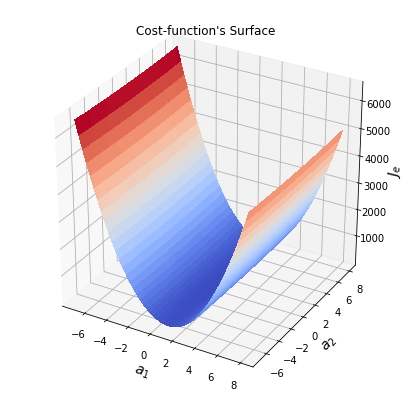

In [107]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

In [108]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

# Hypothesis function.
yhat = X.dot(a_opt)

# Mean Squared Error.
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))
print('Joptimum:', Joptimum)

Joptimum: 0.9692215285411728


**NOTE**.: The value of the learning step below is the highest possible value, higher values ​​cause the algorithm to diverge.

In [109]:
# Number of epochs.
n_epochs = 1

# Learning rate.
alpha_sgd = 0.004

# Training without schedule learning
a_sgd, Jgd, a_hist, update_hist, alpha_hist = sgd(X, y_noisy, n_epochs, 'none', alpha_sgd, 0.01, 0.0, seed)

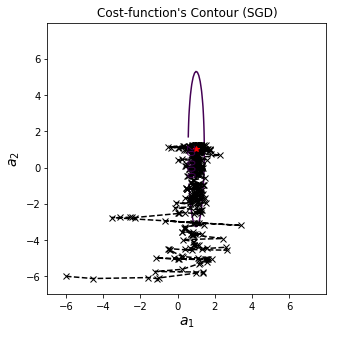

In [110]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J, levels=20)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (SGD)')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-6, 8, step=2.0))
plt.yticks(np.arange(-6, 8, step=2.0))
plt.show()

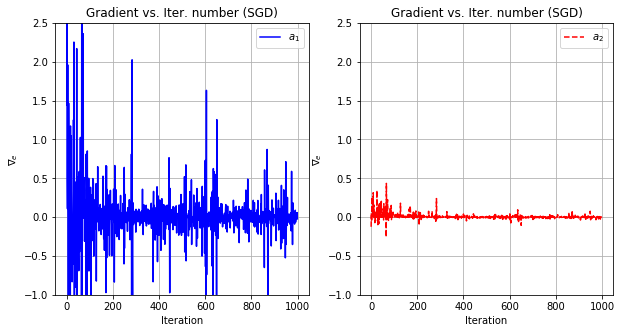

In [111]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1, 2.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (SGD)')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1, 2.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (SGD)')
ax2.legend()
ax2.grid()

plt.show()

In [112]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:',var1)
print('var a2:',var2)

var a1: 0.18916784640413792
var a2: 0.0013627890005954474


**Conclusions**

+ The variance values ​​show that the gradient does not vary equally in both directions.
+ The gradient variance of the weight $a_1$, about 100 times greater than that of the weight $a_2$, indicates that the surface has a very large slope in that direction.
+ Because the error surface is elliptical, the GDE oscillates chaotically along the slopes of the ravine, making slow progress towards the global minimum region.
+ The noise from the gradient vector approximations only make this zig-zag movement worse.
+ Even with the highest possible value for the learning step, the algorithm very slowly approaches the region where the global minimum is found.

<img src="../../../../img/superficie_eliptica.png" width="300px">

### How could we mitigate the flickering issue?

Adding a term to the update of the weights which is the **moving average of previous values ​​of the gradient**, in such a way that the oscillations are smoothed and, consequently, increases the speed of convergence.

<img src="../../../../img/adição_do_termo_momentum.png" width="500px">

### Elliptic surface with momentum term.

In [113]:
# Always reset the pseudo random number generator to the same number.
seed = 1012019
np.random.seed(seed)
random.seed(seed)

In [114]:
# Define the number of examples.
N = 1000

# Features.
x1 = 10*np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2

# Observable model.
y_noisy = y + w

In [115]:
# Generate values for parameters.
M = 200
a1 = np.linspace(-6.0, 8.0, M)
a2 = np.linspace(-6.0, 8.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    for iter2 in range(0, M):
        yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
        J[iter1, iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))

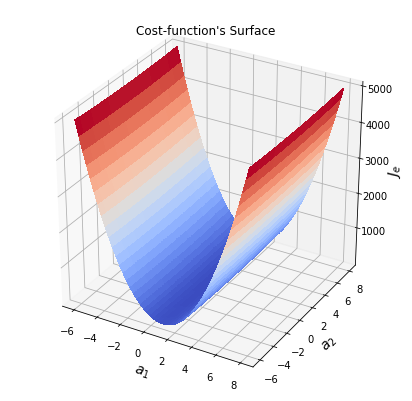

In [116]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

In [117]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

yhat = X.dot(a_opt)
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

print('Joptimum:', Joptimum)

Joptimum: 0.9692215285411728


### Adding momentum term.

+ The momentum coefficient, $\mu$, controls the amount of history (momentum) to include in the equation for updating the weights.

+ A large momentum coefficient, eg 0.9, will mean that the update will be heavily influenced by a large amount of past values, while a small momentum coefficient, eg 0.2, will mean very little influence from history.

In [118]:
# Number of epochs.
n_epochs = 1

# Constant learning rate.
alpha_mom = 0.0006

# Coefficient of momentum.
mu = 0.7

# SGE with momentum term.
a_mom, Jgd, a_hist, update_hist, alpha_hist = sgd(X, y_noisy, n_epochs, 'mom', alpha_mom, 0.01, mu, seed)

+ With momentum, the step size depends on how big and how aligned a sequence of gradients is.

+ The step size is larger when many successive gradients point in exactly the same direction, i.e. it speeds up the convergence and smooths the zig-zag movement.

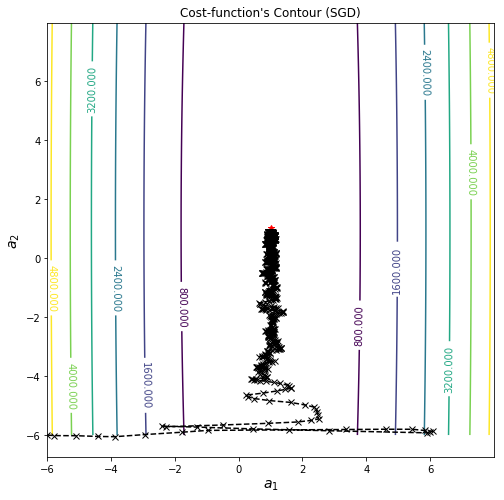

In [122]:
# Plot figure.        
fig = plt.figure(figsize=(8,8))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (SGD)')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-6, 8, step=2.0))
plt.yticks(np.arange(-6, 8, step=2.0))
plt.show()

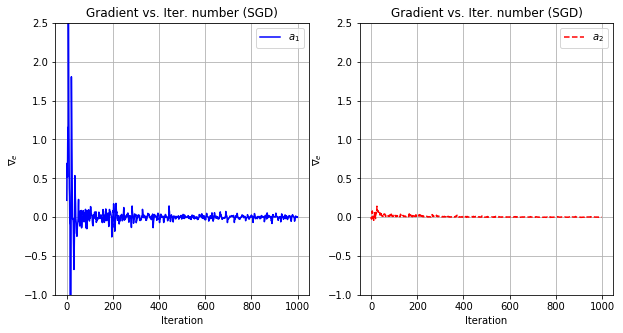

In [120]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1, 2.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (SGD)')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1, 2.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (SGD)')
ax2.legend()
ax2.grid()

plt.show()

+ The momentum term has as main objective to solve the problem of the high variance of the stochastic gradient.

In [121]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:',var1)
print('var a2:',var2)

var a1: 0.04528954061497671
var a2: 0.0001762128842962509


**Benefits**

+ Momentum is useful when the search space is flat or nearly flat, plateau or a ravine (one of the dimensions is quite flat).

+ Momentum allows the search to move in the same direction as before the flat region and cross this region faster.